## Importing packages

In [1]:
import sys
sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import os

## Looking for available devices

In [2]:
# Checking the list of unopened devices
devices = samna.device.get_unopened_devices()

if len(devices) == 0:
    raise Exception("no device detected!")

for i in range(len(devices)):
    print("["+str(i)+"]: ", devices[i], "serial_number", devices[i].serial_number)

[0]:  Bus 3 Device 10 Dynapse1DevKit serial_number 00000007
[1]:  Bus 3 Device 8 Dynapse1DevKit serial_number 00000031
[2]:  Bus 1 Device 21 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 20 Dynapse1DevKit serial_number 00000001


In [3]:
# Select one device from the list
model,no_gui = ut.open_dynapse1(gui=False, sender_port=16754, receiver_port=16623, select_device=True) # returns Dynapse1Model

ERROR: Address already in use, please re-run open_device()!
[0]:  Bus 3 Device 10 Dynapse1DevKit serial_number 00000007
[1]:  Bus 3 Device 8 Dynapse1DevKit serial_number 00000031
[2]:  Bus 1 Device 21 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 20 Dynapse1DevKit serial_number 00000001


Sender port:0 Dynapse1Wrapper created! libcaer init...
 tcp://0.0.0.0:16754
Receiver port: tcp://0.0.0.0:16623
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2
Clearing chip 0... DONE.
Clearing chip 1... DONE.
Clearing chip 2... DONE.
Clearing chip 3... DONE.


In [4]:
def flatten(something):
    if isinstance(something, (list, tuple, set, range)):
        for sub in something:
            yield from flatten(sub)
    else:
        yield something

## Simulation 1 - OR, XOR and AND

### Building the Decoder + Input delays

In [67]:
monitored_neurons = []

# silent all neurons: enforces some biases to ensure neurons are NOT firing
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

api  = model.get_dynapse1_api()

# ---- Spike generator ----
spike_generator_ids = range(1, 10)  # 1, 2, 3 are OP0, OP1 and OP2. 4, 5 and 6 and 7, 8 and 9 are A0, A1, A2, B0, B1, B2 respectively
spike_generators = n.NeuronGroup(0, 0, spike_generator_ids, True)  # Avoid spike generator with ID 0

# --- Extra neurons ---
extra_chip = 0
extra_core = 1
id_end = 20

# ALU INPUT DELAYS
alu_delay_pops = []
for i in range(6):
    id_ini = id_end
    id_end += 3
    alu_delay_pops.append(n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False))
    monitored_neurons.append(id_end - 1)

# DECODER
id_ini = id_end
id_end += 3 * 2
input_layer = n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False)

id_ini = id_end
id_end += 3 * 2 + 1
middle_layer = n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False)

id_ini = id_end
id_end += 4
output_layer = n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False)
monitored_neurons.append(range(id_ini, id_end))

# --- Extra synapses ---
net_gen = n.NetworkGenerator()
total_synapses = 0

# ALU INPUT DELAYS
for i in range(6):
    net_gen.add_connection(spike_generators.neurons[3 + i], alu_delay_pops[i].neurons[0], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    for j in range(1, 3):
        net_gen.add_connection(alu_delay_pops[i].neurons[j - 1], alu_delay_pops[i].neurons[j], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1

# DECODER
# Input layer
for i in range(3): # 2 * n
    net_gen.add_connection(spike_generators.neurons[i], input_layer.neurons[2 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(spike_generators.neurons[i], input_layer.neurons[2 * i + 1], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2
        
    for j in range(i + 1, 3):  # (n - 1) * (1 + (n - 1)) / 2 = (n ^ 2 - n) / 2
        net_gen.add_connection(spike_generators.neurons[i], input_layer.neurons[2 * j + 1], dyn1.Dynapse1SynType.GABA_B)
        total_synapses += 1

# Middle layer
for i in range(3): # 2 * n
    net_gen.add_connection(input_layer.neurons[2 * i], middle_layer.neurons[2 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(input_layer.neurons[2 * i], middle_layer.neurons[2 * i + 1], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # OP to NOT -> n ^ 2
    for j in range(3):   
        net_gen.add_connection(input_layer.neurons[2 * i + 1], middle_layer.neurons[2 * j + 1], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1

    # OP (+1) -> n
    net_gen.add_connection(input_layer.neurons[2 * i + 1], middle_layer.neurons[-1], dyn1.Dynapse1SynType.AMPA)  
    total_synapses += 1

# Output layer 
for i in range(1, 5): # 2 ^ n - 1
    i_bin = format(i, "0" + str(3) + "b")[::-1]

    # Inhibition
    for j in range(len(i_bin)):  
        if i_bin[j] == '1':
            net_gen.add_connection(middle_layer.neurons[2 * j + 1], output_layer.neurons[i - 1], dyn1.Dynapse1SynType.GABA_B)  
        else:
            net_gen.add_connection(middle_layer.neurons[2 * j], output_layer.neurons[i - 1], dyn1.Dynapse1SynType.GABA_B)  
        total_synapses += 1

    # Excitation (OP (+1)) 
    net_gen.add_connection(middle_layer.neurons[-1], output_layer.neurons[i - 1], dyn1.Dynapse1SynType.AMPA)  
    total_synapses += 1

### Building the OR, XOR and AND gates connected to the Decoder

In [68]:
functions_chip = 0  # Only 0 or 2 
functions_core = 1
id_end = 80

# --- BUILD OR ---
# --- Neurons ---
or_pops = []
for i in range(3):
    id_ini = id_end
    id_end += 3
    or_pops.append(n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False))
    monitored_neurons.append(id_end - 1)

# --- Synapses ---
for i in range(3):
    # OP delayed
    net_gen.add_connection(output_layer.neurons[0], or_pops[i].neurons[0], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # OP to NOR
    net_gen.add_connection(output_layer.neurons[0], or_pops[i].neurons[1], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # OP to NOT
    net_gen.add_connection(or_pops[i].neurons[0], or_pops[i].neurons[2], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # Inputs to NOR
    net_gen.add_connection(alu_delay_pops[i].neurons[-1], or_pops[i].neurons[1], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(alu_delay_pops[i + 3].neurons[-1], or_pops[i].neurons[1], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # NOR to NOT
    net_gen.add_connection(or_pops[i].neurons[1], or_pops[i].neurons[2], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 1

        
# --- BUILD XOR ---
# --- Neurons ---
xor_pops = []
for i in range(3):
    id_ini = id_end
    id_end += 4
    xor_pops.append(n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False))
    monitored_neurons.append([id_end - 2, id_end - 1])

# --- Synapses ---
for i in range(3):
    # OP delayed
    net_gen.add_connection(output_layer.neurons[1], xor_pops[i].neurons[0], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(output_layer.neurons[1], xor_pops[i].neurons[1], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2

    # Input delayed
    net_gen.add_connection(alu_delay_pops[i].neurons[-1], xor_pops[i].neurons[0], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(alu_delay_pops[i + 3].neurons[-1], xor_pops[i].neurons[1], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # Not A and B
    net_gen.add_connection(xor_pops[i].neurons[0], xor_pops[i].neurons[2], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(xor_pops[i].neurons[1], xor_pops[i].neurons[2], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # A and not B
    net_gen.add_connection(xor_pops[i].neurons[0], xor_pops[i].neurons[3], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(xor_pops[i].neurons[1], xor_pops[i].neurons[3], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2
        

# --- BUILD AND ---
# --- Neurons ---
and_pops = []
for i in range(3):
    id_ini = id_end
    id_end += 4
    and_pops.append(n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False))
    monitored_neurons.append(id_end - 1)

# --- Synapses ---
for i in range(3):
    # OP delayed
    net_gen.add_connection(output_layer.neurons[2], and_pops[i].neurons[0], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # OP to NOT
    net_gen.add_connection(output_layer.neurons[2], and_pops[i].neurons[1], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(output_layer.neurons[2], and_pops[i].neurons[2], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2

    # Inputs to NOT
    net_gen.add_connection(alu_delay_pops[i].neurons[-1], and_pops[i].neurons[1], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(alu_delay_pops[i + 3].neurons[-1], and_pops[i].neurons[2], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # OP to NOR
    net_gen.add_connection(and_pops[i].neurons[0], and_pops[i].neurons[3], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # NOT to NOR
    net_gen.add_connection(and_pops[i].neurons[1], and_pops[i].neurons[3], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(and_pops[i].neurons[2], and_pops[i].neurons[3], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

### Applying configuration

In [69]:
# make a dynapse1config using the network: that is convert the validated network to a Dynapse1 configuration
new_config = net_gen.make_dynapse1_configuration()

# apply the configuration
model.apply_configuration(new_config)

New configuration applied to DYNAP-SE1!


### Parameters

In [70]:
# Initialize custom parameters for a core and a chip:
paramGroup = dyn1.Dynapse1ParameterGroup() 
paramGroup.param_map["IF_THR_N"].coarse_value = 7
paramGroup.param_map["IF_THR_N"].fine_value = 32
paramGroup.param_map["IF_RFR_N"].coarse_value = 7  # Inverse
paramGroup.param_map["IF_RFR_N"].fine_value = 255  # Inverse
paramGroup.param_map["IF_TAU1_N"].coarse_value = 6  # Inverse
paramGroup.param_map["IF_TAU1_N"].fine_value = 191  # Inverse
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0

# Fast excitatory synapse (AMPA)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 6
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  127
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  127
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255

# Fast inhibitory synapse (GABA_B)
paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 6
paramGroup.param_map["NPDPII_THR_S_P"].fine_value =  127
paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 4
paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 127
paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 255

# Apply the custom parameters to the cores
for i in range(4):
    for j in range(4):
        model.update_parameter_group(paramGroup, i, j)

### Setting spike generators

In [71]:
op0 = np.concatenate([range(10, 19, 1), range(28, 37, 1), [100]], axis=0)
op1 = np.concatenate([range(19, 37, 1), [100]], axis=0)
op2 = np.concatenate([range(37, 46, 1), [100]], axis=0)
a0 = [10, 16, 19, 25, 28, 34, 37, 43]
a1 = [11, 17, 20, 26, 29, 35, 38, 44]
a2 = [12, 18, 21, 27, 30, 36, 39, 45]
b0 = [15, 16, 24, 25, 33, 34, 42, 43]
b1 = [14, 17, 23, 26, 32, 35, 41, 44]
b2 = [13, 18, 22, 27, 31, 36, 40, 45]

factor = 1

sg_times = []
sg_times.append(np.array(op0) / (1000 * factor) + 0.05)
sg_times.append(np.array(op1) / (1000 * factor) + 0.05)
sg_times.append(np.array(op2) / (1000 * factor) + 0.05)
sg_times.append(np.array(a0) / (1000 * factor) + 0.05)
sg_times.append(np.array(a1) / (1000 * factor) + 0.05)
sg_times.append(np.array(a2) / (1000 * factor) + 0.05)
sg_times.append(np.array(b0) / (1000 * factor) + 0.05)
sg_times.append(np.array(b1) / (1000 * factor) + 0.05)
sg_times.append(np.array(b2) / (1000 * factor) + 0.05)
    
def get_results(api, tuples):
    fpga_spike_gen = model.get_fpga_spike_gen()

    spike_times = np.concatenate(sg_times, axis=0)
    gen_neuron_ids = np.concatenate([[i+1] * len(sg_times[i]) for i in range(len(sg_times))], axis=0)  # Spike generator associated to the spike at that index
    spike_times, gen_neuron_ids = map(list, zip(*sorted(zip(spike_times, gen_neuron_ids), reverse=False)))

    post_neuron_chips = []
    for n in gen_neuron_ids:
        post_neuron_chips.append(extra_chip)

    isi_base = 900
    repeat_mode = False
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, gen_neuron_ids, post_neuron_chips, isi_base, repeat_mode)
    graph, filter_node, sink_node = ut.create_neuron_select_graph(model, tuples)

    api.reset_timestamp()
    graph.start()
    sink_node.get_events()
    time.sleep(0.1)
    fpga_spike_gen.start()

    '''if(spike_times[-1] - 0.2 < 0):
        time.sleep(spike_times[-1])
    else:
        time.sleep(spike_times[-1] - 0.2)  # Last spike time - 0.2'''
    time.sleep(0.1)

    fpga_spike_gen.stop()
    #time.sleep(0.5)
    events = sink_node.get_events()
    graph.stop()

    evts_n = np.array([[evt.timestamp / 10**6 + spike_times[0], evt.neuron_id, evt.chip_id, evt.core_id] for evt in events])

    return evts_n

### Getting events

In [72]:
api  = model.get_dynapse1_api()

monitored_neurons = list(flatten(monitored_neurons))

tuples = []
for i in range(len(monitored_neurons)):
    if i < 10:
        tuples.append((extra_chip, extra_core, monitored_neurons[i]))
    else:
        tuples.append((functions_chip, functions_core, monitored_neurons[i]))

events = get_results(api, tuples)
print(events)

VariableIsiMode already 1
RepeatMode already 0
[[  0.160585  51.         0.         1.      ]
 [  0.160613  22.         0.         1.      ]
 [  0.160781  82.         0.         1.      ]
 [  0.161582  25.         0.         1.      ]
 [  0.161586  51.         0.         1.      ]
 [  0.16175   85.         0.         1.      ]
 [  0.162582  28.         0.         1.      ]
 [  0.162586  51.         0.         1.      ]
 [  0.162777  88.         0.         1.      ]
 [  0.163583  37.         0.         1.      ]
 [  0.163586  51.         0.         1.      ]
 [  0.163778  88.         0.         1.      ]
 [  0.164587  51.         0.         1.      ]
 [  0.164605  34.         0.         1.      ]
 [  0.164752  85.         0.         1.      ]
 [  0.165585  31.         0.         1.      ]
 [  0.165588  51.         0.         1.      ]
 [  0.165777  82.         0.         1.      ]
 [  0.166586  31.         0.         1.      ]
 [  0.166588  51.         0.         1.      ]
 [  0.166617 

In [73]:
print(monitored_neurons)
print(tuples)

[22, 25, 28, 31, 34, 37, 51, 52, 53, 54, 82, 85, 88, 91, 92, 95, 96, 99, 100, 104, 108, 112]
[(0, 1, 22), (0, 1, 25), (0, 1, 28), (0, 1, 31), (0, 1, 34), (0, 1, 37), (0, 1, 51), (0, 1, 52), (0, 1, 53), (0, 1, 54), (0, 1, 82), (0, 1, 85), (0, 1, 88), (0, 1, 91), (0, 1, 92), (0, 1, 95), (0, 1, 96), (0, 1, 99), (0, 1, 100), (0, 1, 104), (0, 1, 108), (0, 1, 112)]


## Simulation 2 - ADDER

### Building the Decoder + Input delays

In [74]:
# silent all neurons: enforces some biases to ensure neurons are NOT firing
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

api  = model.get_dynapse1_api()

# ---- Spike generator ----
spike_generator_ids = range(1, 10)  # 1, 2, 3 are OP0, OP1 and OP2. 4, 5 and 6 and 7, 8 and 9 are A0, A1, A2, B0, B1, B2 respectively
spike_generators = n.NeuronGroup(0, 0, spike_generator_ids, True)  # Avoid spike generator with ID 0

# --- Extra neurons ---
extra_chip = 0
extra_core = 1
id_end = 20

# ALU INPUT DELAYS
alu_delay_pops = []
for i in range(6):
    id_ini = id_end
    id_end += 3
    alu_delay_pops.append(n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False))

# DECODER
id_ini = id_end
id_end += 3 * 2
input_layer = n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False)

id_ini = id_end
id_end += 3 * 2 + 1
middle_layer = n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False)

id_ini = id_end
id_end += 4
output_layer = n.NeuronGroup(extra_chip, extra_core, range(id_ini, id_end), False)

# --- Extra synapses ---
net_gen = n.NetworkGenerator()
total_synapses = 0

# ALU INPUT DELAYS
for i in range(6):
    net_gen.add_connection(spike_generators.neurons[3 + i], alu_delay_pops[i].neurons[0], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    for j in range(1, 3):
        net_gen.add_connection(alu_delay_pops[i].neurons[j - 1], alu_delay_pops[i].neurons[j], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1

# DECODER
# Input layer
for i in range(3): # 2 * n
    net_gen.add_connection(spike_generators.neurons[i], input_layer.neurons[2 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(spike_generators.neurons[i], input_layer.neurons[2 * i + 1], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2
        
    for j in range(i + 1, 3):  # (n - 1) * (1 + (n - 1)) / 2 = (n ^ 2 - n) / 2
        net_gen.add_connection(spike_generators.neurons[i], input_layer.neurons[2 * j + 1], dyn1.Dynapse1SynType.GABA_B)
        total_synapses += 1

# Middle layer
for i in range(3): # 2 * n
    net_gen.add_connection(input_layer.neurons[2 * i], middle_layer.neurons[2 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(input_layer.neurons[2 * i], middle_layer.neurons[2 * i + 1], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # OP to NOT -> n ^ 2
    for j in range(3):   
        net_gen.add_connection(input_layer.neurons[2 * i + 1], middle_layer.neurons[2 * j + 1], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1

    # OP (+1) -> n
    net_gen.add_connection(input_layer.neurons[2 * i + 1], middle_layer.neurons[-1], dyn1.Dynapse1SynType.AMPA)  
    total_synapses += 1

# Output layer 
for i in range(1, 5): # 2 ^ n - 1
    i_bin = format(i, "0" + str(3) + "b")[::-1]

    # Inhibition
    for j in range(len(i_bin)):  
        if i_bin[j] == '1':
            net_gen.add_connection(middle_layer.neurons[2 * j + 1], output_layer.neurons[i - 1], dyn1.Dynapse1SynType.GABA_B)  
        else:
            net_gen.add_connection(middle_layer.neurons[2 * j], output_layer.neurons[i - 1], dyn1.Dynapse1SynType.GABA_B)  
        total_synapses += 1

    # Excitation (OP (+1)) 
    net_gen.add_connection(middle_layer.neurons[-1], output_layer.neurons[i - 1], dyn1.Dynapse1SynType.AMPA)  
    total_synapses += 1

### Building the Adder block

In [75]:
adder_chip = 0  # Only 0 or 2 
adder_core = 1
id_end = 170

# --- BUILD ADDER ---
# --- Neurons ---
id_ini = id_end
id_end += 5 * (3 - 1)
op_delay_pop = n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False)

a_delay_pop = []
for i in range(3 - 1):
    id_ini = id_end
    id_end += 2 + 5 * i
    a_delay_pop.append(n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False))

b_delay_pop = []
for i in range(3 - 1):
    id_ini = id_end
    id_end += 2 + 5 * i
    b_delay_pop.append(n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False))

id_ini = id_end
id_end += 6
ha_pop = n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False)
monitored_neurons.append(id_end - 1)

id_ini = id_end
id_end += 18 * (3 - 1)
fa_pop = n.NeuronGroup(functions_chip, functions_core, range(id_ini, id_end), False)
monitored_neurons.append([id_end - 1 - 18, id_end - 1])

# --- Synapses ---
# OP chain
net_gen.add_connection(output_layer.neurons[3], op_delay_pop.neurons[0], dyn1.Dynapse1SynType.AMPA)
total_synapses += 1
for i in range(1, len(op_delay_pop.neurons)):
    net_gen.add_connection(op_delay_pop.neurons[i - 1], op_delay_pop.neurons[i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

# OP to NOT
net_gen.add_connection(output_layer.neurons[3], ha_pop.neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(output_layer.neurons[3], ha_pop.neurons[1], dyn1.Dynapse1SynType.AMPA)
total_synapses += 2
for i in range(3 - 1):
    net_gen.add_connection(op_delay_pop.neurons[1 + 5 * i], fa_pop.neurons[18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(op_delay_pop.neurons[1 + 5 * i], fa_pop.neurons[18 * i + 1], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2
    
# A and B chains -> A0 y B0 are not delayed!
for i in range(1, 3):
    net_gen.add_connection(alu_delay_pops[i].neurons[-1], a_delay_pop[i-1].neurons[0], dyn1.Dynapse1SynType.AMPA)  # A
    net_gen.add_connection(alu_delay_pops[i + 3].neurons[-1], b_delay_pop[i-1].neurons[0], dyn1.Dynapse1SynType.AMPA)  # B
    total_synapses += 2

for i in range(3 - 1):
    for j in range(1, len(a_delay_pop[i].neurons)):
        net_gen.add_connection(a_delay_pop[i].neurons[j - 1], a_delay_pop[i].neurons[j], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1
    for j in range(1, len(b_delay_pop[i].neurons)):
        net_gen.add_connection(b_delay_pop[i].neurons[j - 1], b_delay_pop[i].neurons[j], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1

# Input to NOT
net_gen.add_connection(alu_delay_pops[0].neurons[-1], ha_pop.neurons[0], dyn1.Dynapse1SynType.GABA_B)  # A0
net_gen.add_connection(alu_delay_pops[3].neurons[-1], ha_pop.neurons[1], dyn1.Dynapse1SynType.GABA_B)  # B0
total_synapses += 2
for i in range(3 - 1):
    net_gen.add_connection(a_delay_pop[i].neurons[-1], fa_pop.neurons[18 * i], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(b_delay_pop[i].neurons[-1], fa_pop.neurons[18 * i + 1], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

# ---- HA internal structure ----
# 2
net_gen.add_connection(op_delay_pop.neurons[0], ha_pop.neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(ha_pop.neurons[0], ha_pop.neurons[2], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(ha_pop.neurons[1], ha_pop.neurons[2], dyn1.Dynapse1SynType.GABA_B)
total_synapses += 3

# 3
net_gen.add_connection(ha_pop.neurons[0], ha_pop.neurons[3], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(ha_pop.neurons[1], ha_pop.neurons[3], dyn1.Dynapse1SynType.GABA_B)
total_synapses += 2

# 4
net_gen.add_connection(ha_pop.neurons[0], ha_pop.neurons[4], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(ha_pop.neurons[1], ha_pop.neurons[4], dyn1.Dynapse1SynType.AMPA)
total_synapses += 2

# 5
net_gen.add_connection(ha_pop.neurons[3], ha_pop.neurons[5], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(ha_pop.neurons[4], ha_pop.neurons[5], dyn1.Dynapse1SynType.AMPA)
total_synapses += 2

# Connecting to the next adder
net_gen.add_connection(ha_pop.neurons[2], fa_pop.neurons[2], dyn1.Dynapse1SynType.AMPA)
total_synapses += 1

# ---- FA internal structure ----
for i in range(3 - 1):
    # 3
    net_gen.add_connection(op_delay_pop.neurons[2 + 5 * i], fa_pop.neurons[3 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[0 + 18 * i], fa_pop.neurons[3 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(fa_pop.neurons[1 + 18 * i], fa_pop.neurons[3 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 3

    # 4
    net_gen.add_connection(fa_pop.neurons[0 + 18 * i], fa_pop.neurons[4 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[1 + 18 * i], fa_pop.neurons[4 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # 5
    net_gen.add_connection(fa_pop.neurons[0 + 18 * i], fa_pop.neurons[5 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(fa_pop.neurons[1 + 18 * i], fa_pop.neurons[5 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2

    # 6
    net_gen.add_connection(fa_pop.neurons[2 + 18 * i], fa_pop.neurons[6 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # 7
    net_gen.add_connection(fa_pop.neurons[3 + 18 * i], fa_pop.neurons[7 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # 8
    net_gen.add_connection(op_delay_pop.neurons[3 + 5 * i], fa_pop.neurons[8 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[4 + 18 * i], fa_pop.neurons[8 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(fa_pop.neurons[5 + 18 * i], fa_pop.neurons[8 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 3

    # 9
    net_gen.add_connection(fa_pop.neurons[4 + 18 * i], fa_pop.neurons[9 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[5 + 18 * i], fa_pop.neurons[9 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2

    # 10
    net_gen.add_connection(fa_pop.neurons[6 + 18 * i], fa_pop.neurons[10 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # 11
    net_gen.add_connection(op_delay_pop.neurons[3 + 5 * i], fa_pop.neurons[11 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[6 + 18 * i], fa_pop.neurons[11 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # 12
    net_gen.add_connection(fa_pop.neurons[7 + 18 * i], fa_pop.neurons[12 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 1

    # 13
    net_gen.add_connection(op_delay_pop.neurons[4 + 5 * i], fa_pop.neurons[13 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[8 + 18 * i], fa_pop.neurons[13 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(fa_pop.neurons[11 + 18 * i], fa_pop.neurons[13 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 3

    # 14
    net_gen.add_connection(fa_pop.neurons[9 + 18 * i], fa_pop.neurons[14 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[10 + 18 * i], fa_pop.neurons[14 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    total_synapses += 2

    # 15
    net_gen.add_connection(fa_pop.neurons[9 + 18 * i], fa_pop.neurons[15 + 18 * i], dyn1.Dynapse1SynType.GABA_B)
    net_gen.add_connection(fa_pop.neurons[10 + 18 * i], fa_pop.neurons[15 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2

    # 16
    net_gen.add_connection(fa_pop.neurons[12 + 18 * i], fa_pop.neurons[16 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[13 + 18 * i], fa_pop.neurons[16 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2
    # Connecting to the next adder
    if i != (3 - 2):
        net_gen.add_connection(fa_pop.neurons[16 + 18 * i], fa_pop.neurons[2 + 18 * (i + 1)], dyn1.Dynapse1SynType.AMPA)
        total_synapses += 1

    # 17
    net_gen.add_connection(fa_pop.neurons[14 + 18 * i], fa_pop.neurons[17 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    net_gen.add_connection(fa_pop.neurons[15 + 18 * i], fa_pop.neurons[17 + 18 * i], dyn1.Dynapse1SynType.AMPA)
    total_synapses += 2

### Applying configuration

In [76]:
# make a dynapse1config using the network: that is convert the validated network to a Dynapse1 configuration
new_config = net_gen.make_dynapse1_configuration()

# apply the configuration
model.apply_configuration(new_config)

New configuration applied to DYNAP-SE1!


### Parameters

In [77]:
# Initialize custom parameters for a core and a chip:
paramGroup = dyn1.Dynapse1ParameterGroup() 
paramGroup.param_map["IF_THR_N"].coarse_value = 7
paramGroup.param_map["IF_THR_N"].fine_value = 32
paramGroup.param_map["IF_RFR_N"].coarse_value = 7  # Inverse
paramGroup.param_map["IF_RFR_N"].fine_value = 255  # Inverse
paramGroup.param_map["IF_TAU1_N"].coarse_value = 6  # Inverse
paramGroup.param_map["IF_TAU1_N"].fine_value = 191  # Inverse
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0

# Fast excitatory synapse (AMPA)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 6
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  127
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  127
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255

# Fast inhibitory synapse (GABA_B)
paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 6
paramGroup.param_map["NPDPII_THR_S_P"].fine_value =  127
paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 4
paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 127
paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 255

# Apply the custom parameters to the cores
for i in range(4):
    for j in range(4):
        model.update_parameter_group(paramGroup, i, j)

### Setting spike generators

In [78]:
op0 = np.concatenate([range(10, 19, 1), range(28, 37, 1), [100]], axis=0)
op1 = np.concatenate([range(19, 37, 1), [100]], axis=0)
op2 = np.concatenate([range(37, 46, 1), [100]], axis=0)
a0 = [10, 16, 19, 25, 28, 34, 37, 43]
a1 = [11, 17, 20, 26, 29, 35, 38, 44]
a2 = [12, 18, 21, 27, 30, 36, 39, 45]
b0 = [15, 16, 24, 25, 33, 34, 42, 43]
b1 = [14, 17, 23, 26, 32, 35, 41, 44]
b2 = [13, 18, 22, 27, 31, 36, 40, 45]

factor = 1

sg_times = []
sg_times.append(np.array(op0) / (1000 * factor) + 0.05)
sg_times.append(np.array(op1) / (1000 * factor) + 0.05)
sg_times.append(np.array(op2) / (1000 * factor) + 0.05)
sg_times.append(np.array(a0) / (1000 * factor) + 0.05)
sg_times.append(np.array(a1) / (1000 * factor) + 0.05)
sg_times.append(np.array(a2) / (1000 * factor) + 0.05)
sg_times.append(np.array(b0) / (1000 * factor) + 0.05)
sg_times.append(np.array(b1) / (1000 * factor) + 0.05)
sg_times.append(np.array(b2) / (1000 * factor) + 0.05)
    
def get_results(api, tuples):
    fpga_spike_gen = model.get_fpga_spike_gen()

    spike_times = np.concatenate(sg_times, axis=0)
    gen_neuron_ids = np.concatenate([[i+1] * len(sg_times[i]) for i in range(len(sg_times))], axis=0)  # Spike generator associated to the spike at that index
    spike_times, gen_neuron_ids = map(list, zip(*sorted(zip(spike_times, gen_neuron_ids), reverse=False)))

    post_neuron_chips = []
    for n in gen_neuron_ids:
        post_neuron_chips.append(extra_chip)

    isi_base = 900
    repeat_mode = False
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, gen_neuron_ids, post_neuron_chips, isi_base, repeat_mode)
    graph, filter_node, sink_node = ut.create_neuron_select_graph(model, tuples)

    api.reset_timestamp()
    graph.start()
    sink_node.get_events()
    time.sleep(0.1)
    fpga_spike_gen.start()

    '''if(spike_times[-1] - 0.2 < 0):
        time.sleep(spike_times[-1])
    else:
        time.sleep(spike_times[-1] - 0.2)  # Last spike time - 0.2'''
    time.sleep(0.1)

    fpga_spike_gen.stop()
    #time.sleep(0.5)
    events = sink_node.get_events()
    graph.stop()

    evts_n = np.array([[evt.timestamp / 10**6 + spike_times[0], evt.neuron_id, evt.chip_id, evt.core_id] for evt in events])

    return evts_n

### Getting events

In [79]:
api  = model.get_dynapse1_api()

monitored_neurons = list(flatten(monitored_neurons))

tuples = []
for i in range(len(monitored_neurons)):
    if i < 10:
        tuples.append((extra_chip, extra_core, monitored_neurons[i]))
    else:
        tuples.append((functions_chip, functions_core, monitored_neurons[i]))

events_adder = get_results(api, tuples)
evts_tmp = np.array([evt for evt in events_adder if evt[1] in monitored_neurons[-3:]])
events = np.concatenate([events, evts_tmp])

print(events)

VariableIsiMode already 1
RepeatMode already 0
[[1.60585e-01 5.10000e+01 0.00000e+00 1.00000e+00]
 [1.60613e-01 2.20000e+01 0.00000e+00 1.00000e+00]
 [1.60781e-01 8.20000e+01 0.00000e+00 1.00000e+00]
 [1.61582e-01 2.50000e+01 0.00000e+00 1.00000e+00]
 [1.61586e-01 5.10000e+01 0.00000e+00 1.00000e+00]
 [1.61750e-01 8.50000e+01 0.00000e+00 1.00000e+00]
 [1.62582e-01 2.80000e+01 0.00000e+00 1.00000e+00]
 [1.62586e-01 5.10000e+01 0.00000e+00 1.00000e+00]
 [1.62777e-01 8.80000e+01 0.00000e+00 1.00000e+00]
 [1.63583e-01 3.70000e+01 0.00000e+00 1.00000e+00]
 [1.63586e-01 5.10000e+01 0.00000e+00 1.00000e+00]
 [1.63778e-01 8.80000e+01 0.00000e+00 1.00000e+00]
 [1.64587e-01 5.10000e+01 0.00000e+00 1.00000e+00]
 [1.64605e-01 3.40000e+01 0.00000e+00 1.00000e+00]
 [1.64752e-01 8.50000e+01 0.00000e+00 1.00000e+00]
 [1.65585e-01 3.10000e+01 0.00000e+00 1.00000e+00]
 [1.65588e-01 5.10000e+01 0.00000e+00 1.00000e+00]
 [1.65777e-01 8.20000e+01 0.00000e+00 1.00000e+00]
 [1.66586e-01 3.10000e+01 0.00000e+

In [80]:
print(monitored_neurons)
print(tuples)

[22, 25, 28, 31, 34, 37, 51, 52, 53, 54, 82, 85, 88, 91, 92, 95, 96, 99, 100, 104, 108, 112, 203, 221, 239]
[(0, 1, 22), (0, 1, 25), (0, 1, 28), (0, 1, 31), (0, 1, 34), (0, 1, 37), (0, 1, 51), (0, 1, 52), (0, 1, 53), (0, 1, 54), (0, 1, 82), (0, 1, 85), (0, 1, 88), (0, 1, 91), (0, 1, 92), (0, 1, 95), (0, 1, 96), (0, 1, 99), (0, 1, 100), (0, 1, 104), (0, 1, 108), (0, 1, 112), (0, 1, 203), (0, 1, 221), (0, 1, 239)]


In [81]:
save_array = [sg_times, events, monitored_neurons]

test_name = "alu_2_input_3_bits_factor" + str(factor)
folder_name = "results_ALU"

cwd = os.getcwd()
if not os.path.exists(cwd + "/" + folder_name + "/"):
    os.mkdir(cwd + "/" + folder_name + "/")

i = 1
while os.path.exists(cwd + "/" + folder_name + "/" + test_name + "_" + str(i) + ".pickle"):
    i += 1

filename = test_name + "_" + str(i)

with open(folder_name + "/" + filename + '.pickle', 'wb') as handle:
    pickle.dump(save_array, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(folder_name + "/" + filename + '.pickle', "rb") as handle:
    print(pickle.load(handle))

[[array([0.06 , 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068,
       0.078, 0.079, 0.08 , 0.081, 0.082, 0.083, 0.084, 0.085, 0.086,
       0.15 ]), array([0.069, 0.07 , 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077,
       0.078, 0.079, 0.08 , 0.081, 0.082, 0.083, 0.084, 0.085, 0.086,
       0.15 ]), array([0.087, 0.088, 0.089, 0.09 , 0.091, 0.092, 0.093, 0.094, 0.095,
       0.15 ]), array([0.06 , 0.066, 0.069, 0.075, 0.078, 0.084, 0.087, 0.093]), array([0.061, 0.067, 0.07 , 0.076, 0.079, 0.085, 0.088, 0.094]), array([0.062, 0.068, 0.071, 0.077, 0.08 , 0.086, 0.089, 0.095]), array([0.065, 0.066, 0.074, 0.075, 0.083, 0.084, 0.092, 0.093]), array([0.064, 0.067, 0.073, 0.076, 0.082, 0.085, 0.091, 0.094]), array([0.063, 0.068, 0.072, 0.077, 0.081, 0.086, 0.09 , 0.095])], array([[1.60585e-01, 5.10000e+01, 0.00000e+00, 1.00000e+00],
       [1.60613e-01, 2.20000e+01, 0.00000e+00, 1.00000e+00],
       [1.60781e-01, 8.20000e+01, 0.00000e+00, 1.00000e+00],
       [1.61582e-01, 2.500

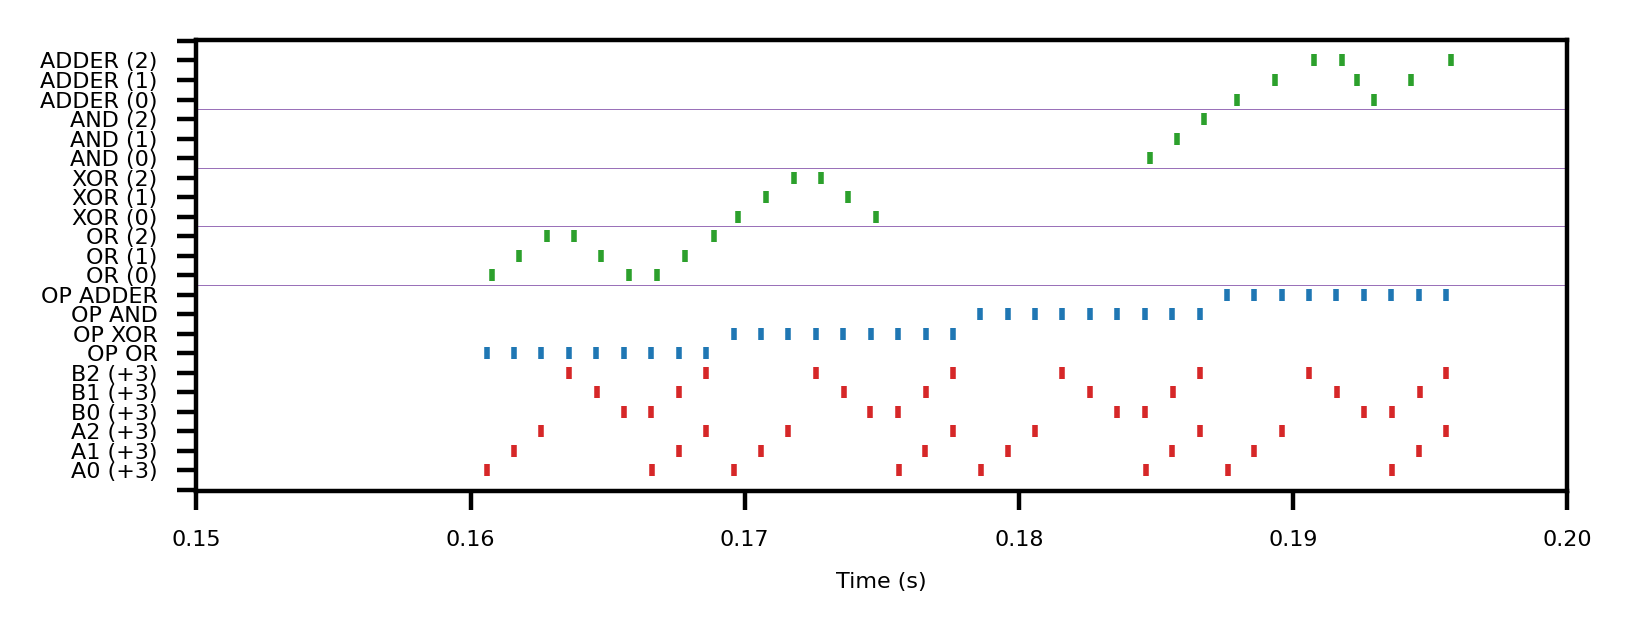

In [82]:
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = '4'
plt.rcParams["figure.figsize"] = (4, 1.5)

# alu input delays
for i in range(6):
    for event in events:
        if event[1] == monitored_neurons[i]:
            plt.plot(event[0], i, '|', markersize=2, color='tab:red')
            
# decoder
for i in range(6, 10):
    for event in events:
        if event[1] == monitored_neurons[i]:
            plt.plot(event[0], i, '|', markersize=2, color='tab:blue')

if factor == 1:
    plt.xlim([0.15, 0.20])
elif factor == 0.5:
    plt.xlim([0.17, 0.245])
elif factor == 0.25:
    plt.xlim([0.225, 2.0])
plt.xlabel('Time (s)')
plt.yticks(range(-1, 23), [""] + ["A" + str(i) + " (+3)" for i in range(3)] + ["B" + str(i) + " (+3)" for i in range(3)] + ["OP OR", "OP XOR", "OP AND", "OP ADDER"] + ["OR (" + str(i) + ")" for i in range(3)] + ["XOR (" + str(i) + ")" for i in range(3)] + ["AND (" + str(i) + ")" for i in range(3)] + ["ADDER (" + str(i) + ")" for i in range(3)] + [""])
plt.hlines([9.5, 12.5, 15.5, 18.5], xmin=0, xmax=5, linewidth=0.1, color="indigo")
            
for j in range(3):
    for event in events:
        # or
        if event[1] == monitored_neurons[10 + j]:
            plt.plot(event[0], 10 + j, '|', markersize=2, color='tab:green')

for j in range(3, 6):
    for event in events:
        # xor
        if event[1] == monitored_neurons[13 + 2 * (j - 3)] or event[1] == monitored_neurons[13 + 2 * (j - 3) + 1]:
            plt.plot(event[0], 10 + j, '|', markersize=2, color='tab:green')

for j in range(6, 9):
    for event in events:
        # and
        if event[1] == monitored_neurons[19 + (j - 6)] or event[1] == monitored_neurons[19 + (j - 6)]:
            plt.plot(event[0], 10 + j, '|', markersize=2, color='tab:green')
                
for j in range(3):
    for event in events:
        # adder
        if event[1] == monitored_neurons[-3 + j]:
            plt.plot(event[0], 19 + j, '|', markersize=2, color='tab:green')

plt.tight_layout()
plt.savefig(folder_name + "/" + filename + '.png', transparent=False, facecolor='white', edgecolor='black')

## Close the device

In [52]:
# remeber to close the device
samna.device.close_device(model)